In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Ejercicio 1: Correlación

#### (a) Grafico de dispersion para pixeles vecinos

In [26]:
#Funcion para formar bloques de pixeles vecinos
def formar_bloques(img):
    X1 = []
    X2 = []
    for i in range(len(img)):
        for j in range(len(img)):
            if j % 2 != 0:
                X1.append(img[i][j])
            else:
                X2.append(img[i][j])
    return np.array([X1, X2])

#Funcion para graficar la imagen y el grafico de dispersion
def grafico_dispersion(X, img, title1, title2):

    fig, axes = plt.subplots(1, 2, figsize = (10, 5))

    # Imagen en grises
    axes[0].imshow(img, cmap = "gray")
    axes[0].set_title(f"{title1}")
    axes[0].axis("off")

    # Gráfico de dispersión
    axes[1].scatter(X[0], X[1], s= 1, alpha = 0.5, color = "darkblue")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(f"{title2}")

    plt.tight_layout()
    plt.show()


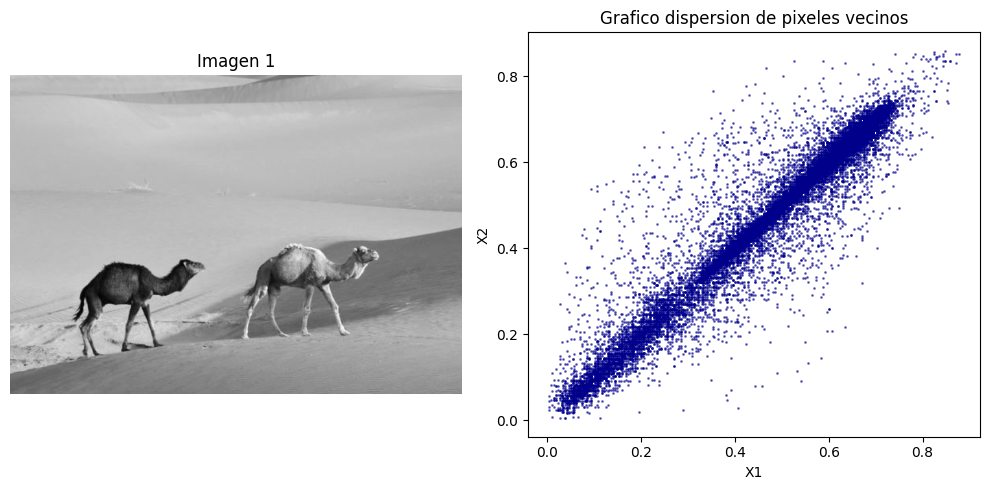

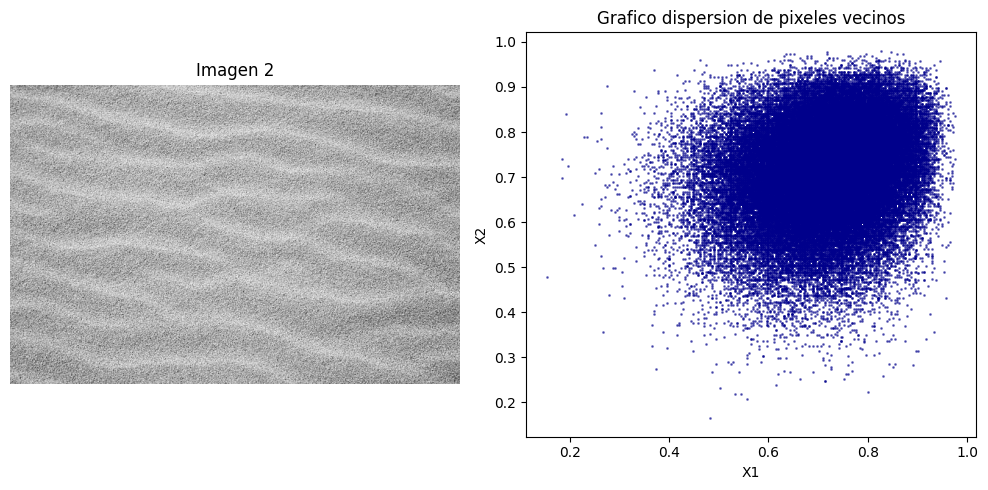

In [27]:
if __name__ == "__main__":
    img1 = Image.open("img_01.jpg").convert("L")
    img2 = Image.open("img_02.jpg").convert("L") #para pasar a escala de grises 
    
    #Convertir a float
    img1_float = np.array(img1, dtype = np.float32) / 255.0
    img2_float = np.array(img2, dtype = np.float32) / 255.0 # astype(float)

    #Grafico de dispersion para pixeles vecinos
    bloques1 = formar_bloques(img1_float)
    bloques2 = formar_bloques(img2_float)

    grafico_dispersion(bloques1, img1_float, "Imagen 1", "Grafico dispersion de pixeles vecinos")
    grafico_dispersion(bloques2, img2_float, "Imagen 2", "Grafico dispersion de pixeles vecinos")
    

#### (b) Estimacion del coeficiente de correlacion

In [28]:
def coef_correlacion(X):
    return np.corrcoef(X[0], X[1])[0,1]

In [29]:
if __name__ == "__main__":
    coef_correlacion_img1 = coef_correlacion(bloques1)
    coef_correlacion_img2 = coef_correlacion(bloques2)

    print(f"Coeficiente de correlacion img1: {coef_correlacion_img1}")
    print(f"Coeficiente de correlacion img2: {coef_correlacion_img2}")

#COMPLETAR CONCLUCION

Coeficiente de correlacion img1: 0.9789974645340295
Coeficiente de correlacion img2: 0.19524647761117764


##### Observamos que para la imagen uno, los pixeles vecinos estan altamente correlacionados, lo que significa que al conocer un pixel podemos deducir de el el valor de su pixel vecio, por lo que hay redundancia. Se puede comprimir con  alta eficiencia y manteniendo la calidad

##### Por otro lado, para la segunda imagen, ocurre el caso contrario. Los pixeles están poco correlacionados, lo que signufica que son independientes, por lo que no se puede deducir el valor de un pixel basandose en su vecino. Esto implica el aumento de bits para comprimir la imagen....

#### (c) Desacoplar 

In [ ]:
def desacoplar(X):
    mu = X.mean(axis = 1, keepdims = True) #opero fila por fila 
    Xc = X - mu #centrado en la media 

    #calculo covarianza entre pixeles vecinos
    Sigma = (Xc @ Xc.T)/ (Xc.shape[1] -1) #hago descomposicion espectral pra conseguir autovectores y autovaores
    eigvals, Q = np.linalg.eigh(Sigma)  #autovalores, autovectores col

    #obtenemos vector Y descorrelacionado
    Y = Q.T @ Xc
    return Y

#### Tras aplicar la descorrelacion por PCA, en ambos casos se logra la descorrelación de las variables, lo cual se evidencia en la ausencia de una nube inclinada. Sin embargo, en la primer imagen la varianza queda concentrada casi totalmente en la componente vertical, indicando que originalmente existía una correlación más fuerte entre los píxeles vecinos. En la segunda imagen, aunque también predomina la componente vertical, la dispersión es mayor en la otra dirección, lo que refleja que la correlación inicial entre píxeles era menor

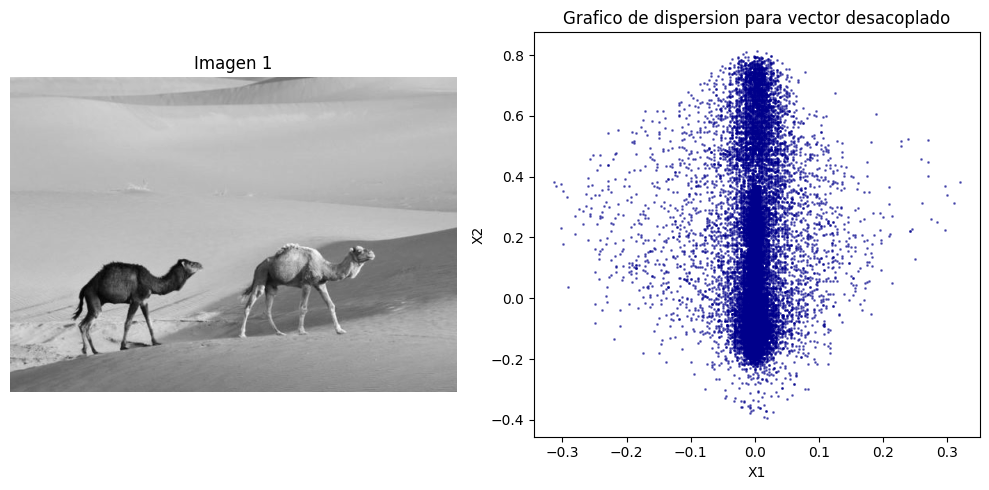

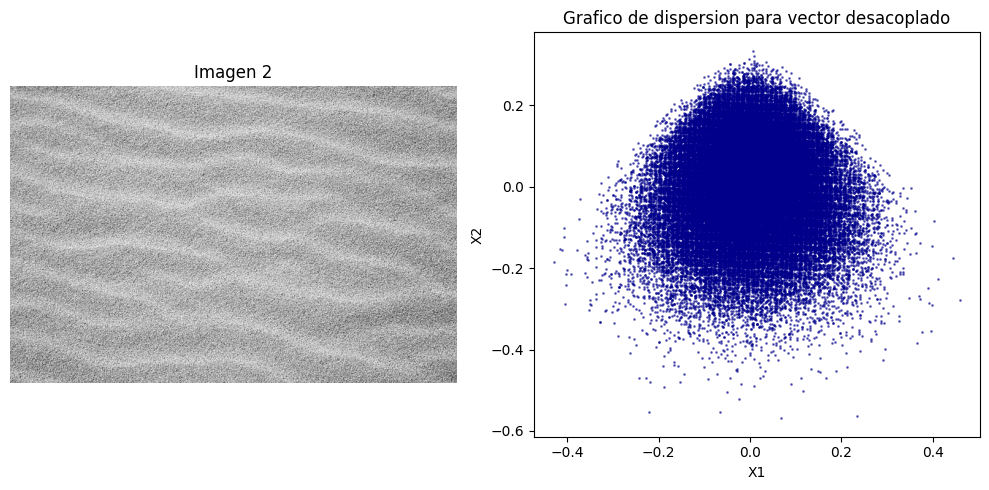

In [31]:
if __name__ == "__main__":
    #imagen desacoplada
    Y1 = desacoplar(bloques1)
    Y2 = desacoplar(bloques2)

    grafico_dispersion(Y1, img1_float, "Imagen 1", "Grafico de dispersion para vector desacoplado")
    grafico_dispersion(Y2, img2_float, "Imagen 2", "Grafico de dispersion para vector desacoplado")

# Ejercicio 2: Compresion

In [32]:

def pca_transform(A):
    # A = USV^t

    autovalores, autovectores = np.linalg.eig()